# USDC Data Cleaning + Feature Engineering + EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning

In [2]:
# load data + standardising column names
df = pd.read_csv("raw_data/usdc_historic_data.csv", sep=";")

df.columns = [c.strip() for c in df.columns]
df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,circulatingSupply,timestamp
0,2023-01-31T00:00:00.000Z,2023-01-31T23:59:59.999Z,2023-01-31T22:52:00.000Z,2023-01-31T21:19:00.000Z,2781,1.000021,1.000431,0.999650,1.000058,2.960610e+09,4.240536e+10,4.240290e+10,2023-01-31T23:59:59.999Z
1,2023-01-30T00:00:00.000Z,2023-01-30T23:59:59.999Z,2023-01-30T21:13:00.000Z,2023-01-30T19:13:00.000Z,2781,1.000075,1.000333,0.999503,1.000101,3.562976e+09,4.271273e+10,4.270842e+10,2023-01-30T23:59:59.999Z
2,2023-01-29T00:00:00.000Z,2023-01-29T23:59:59.999Z,2023-01-29T19:17:00.000Z,2023-01-29T02:10:00.000Z,2781,1.000114,1.000393,0.999655,1.000001,2.963259e+09,4.308608e+10,4.308603e+10,2023-01-29T23:59:59.999Z
3,2023-01-28T00:00:00.000Z,2023-01-28T23:59:59.999Z,2023-01-28T00:49:00.000Z,2023-01-28T20:58:00.000Z,2781,0.999982,1.000265,0.999635,1.000130,2.554817e+09,4.309304e+10,4.308745e+10,2023-01-28T23:59:59.999Z
4,2023-01-27T00:00:00.000Z,2023-01-27T23:59:59.999Z,2023-01-27T14:52:00.000Z,2023-01-27T01:39:00.000Z,2781,0.999980,1.000388,0.999580,1.000027,3.615690e+09,4.308538e+10,4.308423e+10,2023-01-27T23:59:59.999Z


In [3]:
# parse datetimes + numerics
time_cols = ["timeOpen", "timeClose", "timeHigh", "timeLow", "timestamp"]
for c in time_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

num_cols = ["open","high","low","close","volume","marketCap","circulatingSupply"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.dtypes

timeOpen             datetime64[ns, UTC]
timeClose            datetime64[ns, UTC]
timeHigh             datetime64[ns, UTC]
timeLow              datetime64[ns, UTC]
name                               int64
open                             float64
high                             float64
low                              float64
close                            float64
volume                           float64
marketCap                        float64
circulatingSupply                float64
timestamp            datetime64[ns, UTC]
dtype: object

In [4]:
# drop duplicates (same timestamp)
print(f"Number of rows before dropping duplicates: {len(df)}")
df = df.sort_values("timestamp")
df = df.drop_duplicates(subset=["timestamp"], keep="last")
print(f"Number of rows after dropping duplicates: {len(df)}")

Number of rows before dropping duplicates: 400
Number of rows after dropping duplicates: 400


In [5]:
df["date"] = df["timestamp"].dt.floor("D")

df_daily = (
    df.groupby("date", as_index=False)
      .agg({
          "open": "first",
          "close": "last",
          "high": "max",
          "low": "min",
          "volume": "sum",
          "marketCap": "last",
          "circulatingSupply": "last",
          "timeOpen": "min",
          "timeClose": "max",
          "timeHigh": "first",   # timing features refined later
          "timeLow": "first",
          "name": "last",
          "timestamp": "last"
      })
)

df = df_daily.sort_values("date").set_index("date")
df.head()

,open,close,high,low,volume,marketCap,circulatingSupply,timeOpen,timeClose,timeHigh,timeLow,name,timestamp
date,,,,,,,,,,,,,
2021-12-28 00:00:00+00:00,0.999633,1.000841,1.001997,0.998165,4.171719e+09,4.213012e+10,4.209473e+10,2021-12-28 00:00:00+00:00,2021-12-28 23:59:59.999000+00:00,2021-12-28 07:14:05+00:00,2021-12-28 16:04:05+00:00,2781,2021-12-28 23:59:59.999000+00:00
2021-12-29 00:00:00+00:00,1.000758,0.999463,1.001935,0.998229,3.506507e+09,4.211677e+10,4.213939e+10,2021-12-29 00:00:00+00:00,2021-12-29 23:59:59.999000+00:00,2021-12-29 11:36:06+00:00,2021-12-29 22:18:06+00:00,2781,2021-12-29 23:59:59.999000+00:00
2021-12-30 00:00:00+00:00,0.999622,1.000346,1.001807,0.998104,3.137476e+09,4.231572e+10,4.230110e+10,2021-12-30 00:00:00+00:00,2021-12-30 23:59:59.999000+00:00,2021-12-30 05:32:06+00:00,2021-12-30 14:23:06+00:00,2781,2021-12-30 23:59:59.999000+00:00
2021-12-31 00:00:00+00:00,1.000383,1.000039,1.000933,0.999184,3.283687e+09,4.216772e+10,4.216608e+10,2021-12-31 00:00:00+00:00,2021-12-31 23:59:59.999000+00:00,2021-12-31 10:56:00+00:00,2021-12-31 20:52:00+00:00,2781,2021-12-31 23:59:59.999000+00:00
2022-01-01 00:00:00+00:00,1.000083,1.000085,1.000861,0.999217,2.655459e+09,4.245494e+10,4.245132e+10,2022-01-01 00:00:00+00:00,2022-01-01 23:59:59.999000+00:00,2022-01-01 08:47:00+00:00,2022-01-01 21:53:00+00:00,2781,2022-01-01 23:59:59.999000+00:00


In [6]:
# regularise to daily frequency (fills missing dates if any)
df = df.asfreq("D")

### Basic Price Sanity Checks

In [7]:
# low/high must be positive and low <= high
bad_hl = (df["low"] <= 0) | (df["high"] <= 0) | (df["low"] > df["high"])
df.loc[bad_hl, ["low","high"]] = np.nan

# refill short gaps
df[["low","high"]] = df[["low","high"]].ffill().bfill()

### USDC-Specific Outlier Handling (Tight Bounds)
USDC is our **control coin**, so we should treat extreme prints as likely data artefacts.

In [8]:
LOW_FLOOR = 0.995   # tighten/loosen in robustness checks
HIGH_CEIL = 1.005

df.loc[df["low"] < LOW_FLOOR, "low"] = np.nan
df.loc[df["high"] > HIGH_CEIL, "high"] = np.nan

df[["low","high"]] = df[["low","high"]].ffill().bfill()

### Time Sanity Checks (Drop Bad Timing)
Keep the price data even if timing is nonsense.

In [9]:
# ensure timeHigh/timeLow fall within the daily open-close window
bad_high_time = (df["timeHigh"] < df["timeOpen"]) | (df["timeHigh"] > df["timeClose"])
bad_low_time  = (df["timeLow"]  < df["timeOpen"]) | (df["timeLow"]  > df["timeClose"])

df.loc[bad_high_time, "timeHigh"] = pd.NaT
df.loc[bad_low_time,  "timeLow"]  = pd.NaT

## Feature Engineering

### Peg Deviation + Intraday Stress

In [10]:
PEG = 1.0

df["price_dev"] = df["close"] - PEG
df["abs_price_dev"] = df["price_dev"].abs()
df['rel_price_dev'] = df['price_dev'] / PEG

In [11]:
df["intraday_range"] = (df["high"] - df["low"]) / df["close"]
df["downside_dev"] = (PEG - df["low"]).clip(lower=0)  # only downside stress

### Returns + Volatility (Might Be Useful)

In [12]:
df["ret_1d"] = df["close"].pct_change()
df["vol_7d"] = df["ret_1d"].rolling(7, min_periods=5).std()

### Volume Cleaning + Abnormal Volume (Z-Score)

In [13]:
df.loc[df["volume"] <= 0, "volume"] = np.nan

df["log_volume"] = np.log1p(df["volume"].clip(lower=0))
df["volume_z_30d"] = (
    (df["log_volume"] - df["log_volume"].rolling(30, min_periods=10).mean()) /
    df["log_volume"].rolling(30, min_periods=10).std().replace(0, np.nan)
)

In [14]:
df['turnover'] = df['volume'] / df['circulatingSupply']
df['range_expansion'] = df['intraday_range'] / df['intraday_range'].rolling(7).mean()

* raw volume is heavily-tailed
* usdc volume regimes change structurally

In [15]:
df['log_volume'] = np.log1p(df['volume'])
df['volume_zscore'] = (
    df['log_volume'] - df['log_volume'].rolling(30).mean()
) / df['log_volume'].rolling(30).std()

### Time-between-high-low Features

In [16]:
# signed time difference (hours)
df["timing_asymmetry_hours"] = (df["timeHigh"] - df["timeLow"]).dt.total_seconds() / 3600

# recovery time: low -> high (only if high happens after low)
df["recovery_time_hours"] = (df["timeHigh"] - df["timeLow"]).dt.total_seconds() / 3600
df.loc[df["timeHigh"] < df["timeLow"], "recovery_time_hours"] = np.nan

# collapse time: high -> low (only if low happens after high)
df["collapse_time_hours"] = (df["timeLow"] - df["timeHigh"]).dt.total_seconds() / 3600
df.loc[df["timeLow"] < df["timeHigh"], "collapse_time_hours"] = np.nan

# cap absurd timing (>24h at daily level is likely data artefact)
df.loc[df["recovery_time_hours"] > 24, "recovery_time_hours"] = np.nan
df.loc[df["collapse_time_hours"] > 24, "collapse_time_hours"] = np.nan

# focus recovery time on stress days (otherwise it's mostly noise)
STRESS_LOW = 0.999
df.loc[df["low"] >= STRESS_LOW, "recovery_time_hours"] = np.nan

### False Alarm Thresholds (Pre-crash Calibration for a Control Coin)

In [17]:
# define baseline period for threshold setting

baseline = df.loc["2021-01-01":"2022-03-31"].copy()

thr_range_99 = baseline["intraday_range"].quantile(0.99)
thr_recovery_99 = baseline["recovery_time_hours"].quantile(0.99)

thr_range_99, thr_recovery_99

(0.0038342178962468857, 15.952333333333334)

In [18]:
# create usdc signals (should be rare events)
df["signal_intraday_range"] = df["intraday_range"] > thr_range_99
df["signal_slow_recovery"] = df["recovery_time_hours"] > thr_recovery_99

df[["signal_intraday_range","signal_slow_recovery"]].mean()

signal_intraday_range    0.0025
signal_slow_recovery     0.0050
dtype: float64

In [19]:
df.tail(10)[[
    "open","high","low","close",
    "abs_price_dev","intraday_range","downside_dev",
    "recovery_time_hours","collapse_time_hours",
    "volume_z_30d",
    "signal_intraday_range","signal_slow_recovery"
]]

,open,high,low,close,abs_price_dev,intraday_range,downside_dev,recovery_time_hours,collapse_time_hours,volume_z_30d,signal_intraday_range,signal_slow_recovery
date,,,,,,,,,,,,
2023-01-22 00:00:00+00:00,0.999861,1.000386,0.999431,0.999976,0.000024,0.000955,0.000569,NaN,8.083333,0.791310,False,False
2023-01-23 00:00:00+00:00,0.999837,1.000426,0.999423,0.999858,0.000142,0.001003,0.000577,NaN,0.116667,0.896733,False,False
2023-01-24 00:00:00+00:00,0.999826,1.000321,0.999089,0.999958,0.000042,0.001232,0.000911,NaN,20.133333,0.953218,False,False
2023-01-25 00:00:00+00:00,0.999933,1.000506,0.999500,1.000062,0.000062,0.001006,0.000500,NaN,NaN,1.274292,False,False
2023-01-26 00:00:00+00:00,1.000029,1.000339,0.999628,0.999960,0.000040,0.000710,0.000372,NaN,14.150000,0.568011,False,False
2023-01-27 00:00:00+00:00,0.999980,1.000388,0.999580,1.000027,0.000027,0.000808,0.000420,NaN,NaN,0.803568,False,False
2023-01-28 00:00:00+00:00,0.999982,1.000265,0.999635,1.000130,0.000130,0.000629,0.000365,NaN,20.150000,-0.173433,False,False
2023-01-29 00:00:00+00:00,1.000114,1.000393,0.999655,1.000001,0.000001,0.000738,0.000345,NaN,NaN,0.199500,False,False
2023-01-30 00:00:00+00:00,1.000075,1.000333,0.999503,1.000101,0.000101,0.000830,0.000497,NaN,NaN,0.675761,False,False


In [20]:
pd.set_option("display.max_columns", None)
print(df.tail())

                               open     close      high       low  \
date                                                                
2023-01-27 00:00:00+00:00  0.999980  1.000027  1.000388  0.999580   
2023-01-28 00:00:00+00:00  0.999982  1.000130  1.000265  0.999635   
2023-01-29 00:00:00+00:00  1.000114  1.000001  1.000393  0.999655   
2023-01-30 00:00:00+00:00  1.000075  1.000101  1.000333  0.999503   
2023-01-31 00:00:00+00:00  1.000021  1.000058  1.000431  0.999650   

                                 volume     marketCap  circulatingSupply  \
date                                                                       
2023-01-27 00:00:00+00:00  3.615690e+09  4.308538e+10       4.308423e+10   
2023-01-28 00:00:00+00:00  2.554817e+09  4.309304e+10       4.308745e+10   
2023-01-29 00:00:00+00:00  2.963259e+09  4.308608e+10       4.308603e+10   
2023-01-30 00:00:00+00:00  3.562976e+09  4.271273e+10       4.270842e+10   
2023-01-31 00:00:00+00:00  2.960610e+09  4.240536e+10       

For USDC, all proposed indicators remain largely inactive, exhibiting low volatility, rapid intraday adjustment, and minimal false alarms across the sample period.

In [21]:
df.to_csv("clean_data/cleaned_usdc.csv", index=True)

In [28]:
pd.read_csv("clean_data/cleaned_usdc.csv").head()

,date,open,close,high,low,volume,marketCap,circulatingSupply,timeOpen,timeClose,timeHigh,timeLow,name,timestamp,price_dev,abs_price_dev,rel_price_dev,intraday_range,downside_dev,ret_1d,vol_7d,log_volume,volume_z_30d,turnover,range_expansion,volume_zscore,timing_asymmetry_hours,recovery_time_hours,collapse_time_hours,signal_intraday_range,signal_slow_recovery
0,2021-12-28 00:00:00+00:00,0.999633,1.000841,1.001997,0.998165,4.171719e+09,4.213012e+10,4.209473e+10,2021-12-28 00:00:00+00:00,2021-12-28 23:59:59.999000+00:00,2021-12-28 07:14:05+00:00,2021-12-28 16:04:05+00:00,2781,2021-12-28 23:59:59.999000+00:00,0.000841,0.000841,0.000841,0.003828,0.001835,NaN,NaN,22.151594,NaN,0.099103,NaN,NaN,-8.833333,NaN,8.833333,False,False
1,2021-12-29 00:00:00+00:00,1.000758,0.999463,1.001935,0.998229,3.506507e+09,4.211677e+10,4.213939e+10,2021-12-29 00:00:00+00:00,2021-12-29 23:59:59.999000+00:00,2021-12-29 11:36:06+00:00,2021-12-29 22:18:06+00:00,2781,2021-12-29 23:59:59.999000+00:00,-0.000537,0.000537,-0.000537,0.003708,0.001771,-0.001376,NaN,21.977886,NaN,0.083212,NaN,NaN,-10.700000,NaN,10.700000,False,False
2,2021-12-30 00:00:00+00:00,0.999622,1.000346,1.001807,0.998104,3.137476e+09,4.231572e+10,4.230110e+10,2021-12-30 00:00:00+00:00,2021-12-30 23:59:59.999000+00:00,2021-12-30 05:32:06+00:00,2021-12-30 14:23:06+00:00,2781,2021-12-30 23:59:59.999000+00:00,0.000346,0.000346,0.000346,0.003702,0.001896,0.000883,NaN,21.866685,NaN,0.074170,NaN,NaN,-8.850000,NaN,8.850000,False,False
3,2021-12-31 00:00:00+00:00,1.000383,1.000039,1.000933,0.999184,3.283687e+09,4.216772e+10,4.216608e+10,2021-12-31 00:00:00+00:00,2021-12-31 23:59:59.999000+00:00,2021-12-31 10:56:00+00:00,2021-12-31 20:52:00+00:00,2781,2021-12-31 23:59:59.999000+00:00,0.000039,0.000039,0.000039,0.001749,0.000816,-0.000307,NaN,21.912233,NaN,0.077875,NaN,NaN,-9.933333,NaN,9.933333,False,False
4,2022-01-01 00:00:00+00:00,1.000083,1.000085,1.000861,0.999217,2.655459e+09,4.245494e+10,4.245132e+10,2022-01-01 00:00:00+00:00,2022-01-01 23:59:59.999000+00:00,2022-01-01 08:47:00+00:00,2022-01-01 21:53:00+00:00,2781,2022-01-01 23:59:59.999000+00:00,0.000085,0.000085,0.000085,0.001643,0.000783,0.000046,NaN,21.699883,NaN,0.062553,NaN,NaN,-13.100000,NaN,13.100000,False,False


## EDA

### Price + Peg Deviation (Baseline Sanity Plot)

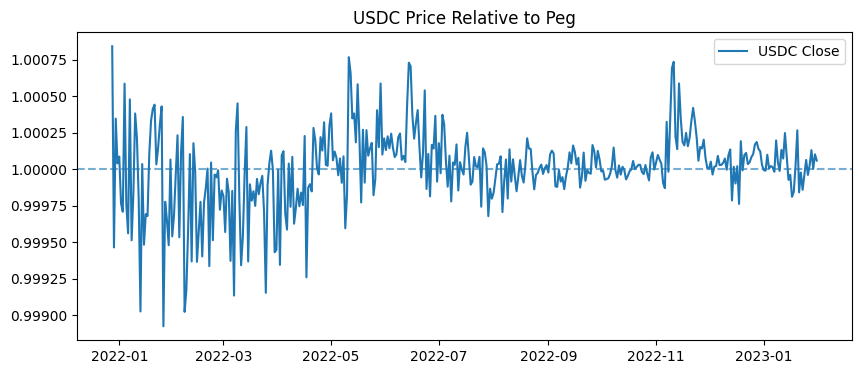

In [22]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df.index, df["close"], label="USDC Close")
ax.axhline(1.0, linestyle="--", alpha=0.6)
ax.set_title("USDC Price Relative to Peg")
ax.legend()

USDC remains tightly anchored to its peg throughout the sample period.

### Intraday Range Over Time (Key Stress Plot)

Text(0.5, 1.0, 'USDC Intraday Range (Stress Indicator)')

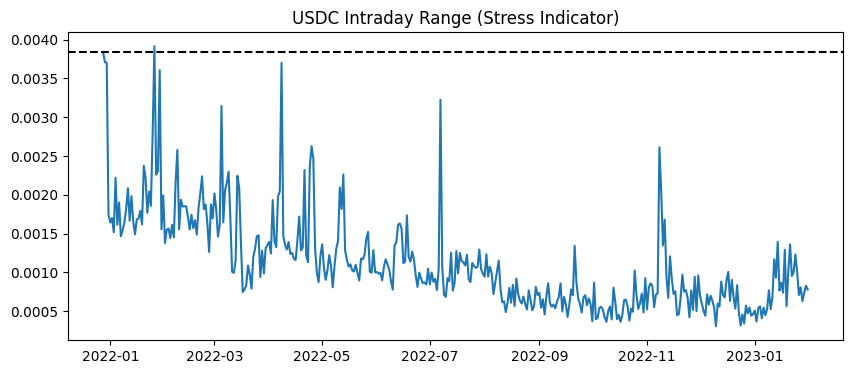

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df.index, df["intraday_range"])
ax.axhline(thr_range_99, linestyle="--", color="black")
ax.set_title("USDC Intraday Range (Stress Indicator)")

Clear downward trend in intraday stress over 2022 with occasional spikes early in the year. The dashed threshold is almost never breached


This implies that market microstructure improves, not deteriorates and there is no build-up of instability. The threshold line visually reinforces “false alarms are rare”

### Recovery Time Distribution

Text(0.5, 0, 'Hours')

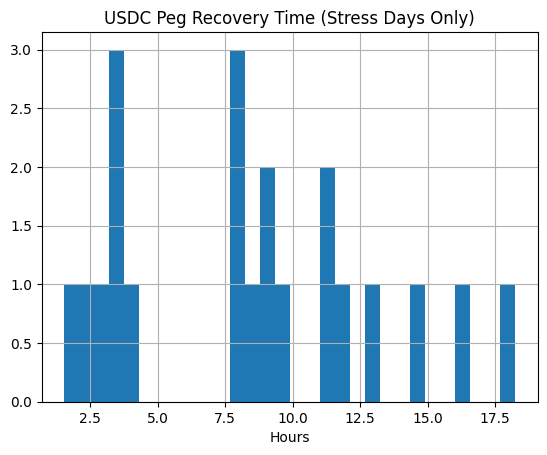

In [24]:
df["recovery_time_hours"].dropna().hist(bins=30)
plt.title("USDC Peg Recovery Time (Stress Days Only)")
plt.xlabel("Hours")

### Volume vs Intraday Stress

Text(0.5, 1.0, 'USDC Volume vs Price Stress')

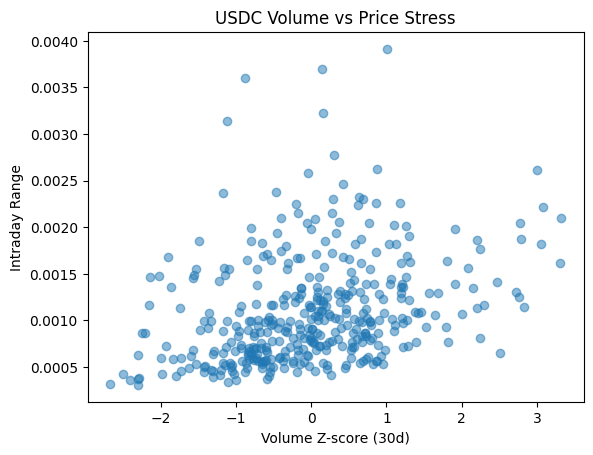

In [25]:
plt.scatter(df["volume_z_30d"], df["intraday_range"], alpha=0.5)
plt.xlabel("Volume Z-score (30d)")
plt.ylabel("Intraday Range")
plt.title("USDC Volume vs Price Stress")

There is a weak positive relationship with no obvious clusters. High volume does not systematically imply stress

Stress indicators are not just “volume proxies”. Liquidity shocks do not mechanically cause price instability.

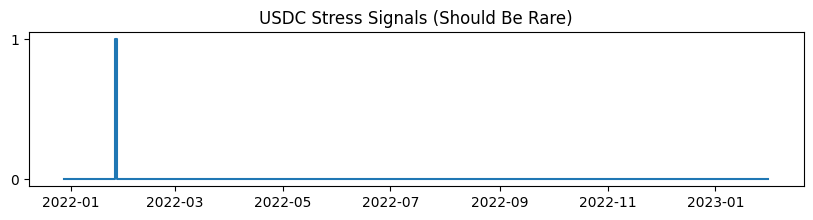

In [26]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(df.index, df["signal_intraday_range"].astype(int), drawstyle="steps-post")
ax.set_title("USDC Stress Signals (Should Be Rare)")
ax.set_yticks([0,1])

The proposed indicators exhibit low false-alarm rates for fiat-backed stablecoins.